In [1]:
ANDRE_REFERENCE_DATA = "../../test_data/system_tests/maxquant_yeast_interactome/1_Final_run_5x_1800_files/#1/evidence.txt.maxquant_evidence_andre_benchmark.aq_reformat.tsv"

In [5]:
#create a pandas dataframe with 100 rows and 10.000 columns
import pandas as pd
import numpy as np
import time

num_samples = 1000
num_proteins = 4000
df = pd.DataFrame(np.random.default_rng().normal(loc=100,scale= 30,size=(num_proteins, num_samples)), columns=list(range(num_samples)))
#create array of random integers of size num_samples
scaling_factors = np.random.default_rng().integers(low=10, high=1000, size=num_samples)

#add scaling factors to columns
for i in range(num_samples):
    df[i] = df[i] + scaling_factors[i]

mask = np.random.choice([0, 1], size=(num_proteins, num_samples), p=[0.8, 0.2])
#apply mask to df
df = df.mask(mask == 1)
display(df)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,764.464488,858.310473,NaN,NaN,1053.920007,346.919921,997.267205,745.614897,NaN,722.439979,...,NaN,634.073154,754.957883,143.448909,897.946171,1094.847692,906.615584,995.308126,277.316778,807.046288
1,756.226189,859.767742,154.868315,NaN,1063.762302,338.689380,970.301940,730.662689,822.292160,758.500052,...,136.200010,574.590326,NaN,NaN,861.076093,NaN,895.289621,949.607126,202.261757,823.607510
2,NaN,872.474647,179.055203,224.959532,1064.965068,357.753437,1013.217745,745.597816,NaN,777.200500,...,91.361021,589.358034,NaN,NaN,NaN,1073.786459,NaN,967.538109,NaN,770.094273
3,757.725479,854.897950,129.963242,191.069321,1019.337584,352.147783,988.389987,NaN,865.766449,NaN,...,90.200954,683.330459,752.756132,143.531977,864.897925,NaN,912.061115,966.750907,273.925726,810.404630
4,769.314581,840.978726,197.851592,227.203713,NaN,348.711836,952.502994,NaN,833.282973,754.431552,...,139.975549,573.031799,NaN,152.471897,762.955535,1090.911870,921.565805,986.558881,359.471174,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,746.168681,887.443311,117.973275,200.220366,1018.277394,369.838148,970.818132,NaN,920.802907,724.987118,...,122.891380,588.019937,NaN,NaN,852.636502,1065.387461,NaN,934.167027,270.015995,839.180362
3996,NaN,NaN,NaN,NaN,1066.197945,NaN,952.822004,673.156930,836.373329,697.324216,...,153.915306,629.827130,NaN,167.581842,837.097471,1146.702871,909.274414,965.799034,279.603696,NaN
3997,757.909463,896.742446,170.476670,233.608018,NaN,427.797179,1009.817419,792.204134,812.025047,808.422927,...,114.533257,619.329408,NaN,166.788880,895.118581,1144.914543,885.997005,943.622144,211.009690,NaN
3998,759.530114,793.506251,156.201168,225.373642,1016.132788,347.196466,1048.949145,782.589962,889.784583,724.165655,...,130.594055,642.307104,NaN,115.509535,871.357183,NaN,NaN,947.849703,238.949096,790.915641


In [6]:
import directlfq.normalization

class NormalizationManagerSamplesOnSelectedProteinsDirectInput(directlfq.normalization.NormalizationManagerSamples):
    def __init__(self, complete_dataframe, num_samples_quadratic, selected_protein_groups):
        complete_dataframe = complete_dataframe.T #the samples to shift are in each row, therefore the df needs to be transposed
        self._selected_protein_groups = selected_protein_groups
        super().__init__(complete_dataframe, num_samples_quadratic)
        self.normalization_function = self._normalization_function
        self._run_normalization()
        self.complete_dataframe = complete_dataframe.T

    def _adapt_selected_proteins_to_protein_groups(self):
        if self._selected_proteins_file is not None:
            print('Normalizing only selected proteins')
            selected_proteins = pd.read_csv(self._selected_proteins_file, header=None, sep='\t')[0].to_list()
            protein2proteingroup_mapping = self._get_protein2proteingroup_mapping()
            existing_selected_proteins = [protein for protein in selected_proteins if protein in protein2proteingroup_mapping.keys()]
            self._selected_protein_groups = [protein2proteingroup_mapping[protein] for protein in existing_selected_proteins]

    def _get_protein2proteingroup_mapping(self):
        protein_groups = self.complete_dataframe.columns.get_level_values(0).to_list()
        protein2proteingroup_mapping = {protein : protein_group for protein_group in protein_groups for protein in protein_group.split(';')}
        return protein2proteingroup_mapping

    def _normalization_function(self, ion_dataframe):
        if self._selected_protein_groups is not None:
            ion_dataframe_selected = ion_dataframe.loc[:,self._selected_protein_groups]
        else:
            ion_dataframe_selected = ion_dataframe
        sample2shift = directlfq.normalization.get_normfacts(directlfq.normalization.drop_nas_if_possible(ion_dataframe_selected).to_numpy())
        df_c_normed = pd.DataFrame(directlfq.normalization.apply_sampleshifts(ion_dataframe.to_numpy(), sample2shift), index = ion_dataframe.index, columns = ion_dataframe.columns)
        return df_c_normed

    def _create_reference_sample(self):
        quadratic_subset_dataframe = self.complete_dataframe.loc[self._quadratic_subset_rows, self._selected_protein_groups]
        self._merged_reference_sample = quadratic_subset_dataframe.median(axis=0)

    def _shift_remaining_dataframe_to_reference_sample(self):
        linear_subset_dataframe = self.complete_dataframe.loc[self._linear_subset_rows]
        linear_shifted_dataframe = directlfq.normalization.SampleShifterLinear(linear_subset_dataframe, self._merged_reference_sample, protein_subset = self._selected_protein_groups).ion_dataframe
        self.complete_dataframe.loc[ self._linear_subset_rows, :] = linear_shifted_dataframe

    

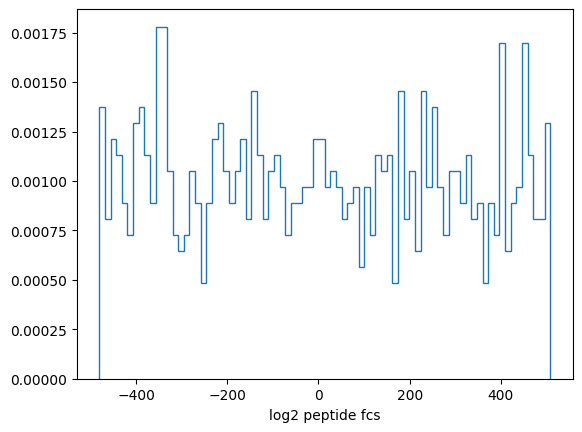

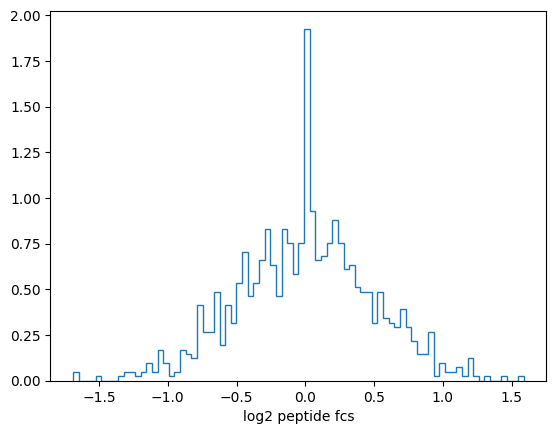

to few values for normalization without missing values. Including missing values


KeyError: '[3520, 3573, 1675, 3481, 2243, 2477, 1552, 3162, 2496, 1047, 3496, 3697, 2324, 3374, 2170, 3532, 2482, 2136, 2082, 3076, 3659, 3664, 2874, 2473, 2241, 1072, 2064, 3671, 3469, 2962, 2594, 2261, 1425, 1158, 3059, 1859, 2806, 1719, 2755, 1903, 2734, 1172, 2043, 3397, 3248, 1671, 2191, 1440, 3167, 1372, 3624, 3541, 3269, 2183, 2685, 1617, 2417, 1002, 2208, 1885, 2607, 3995, 3561, 3535, 3882, 1455, 2019, 3337, 2265, 1809, 3801, 3252, 2932] not in index'

In [7]:
import directlfq.normalization
import directlfq.utils as lfq_utils
import random

def visualize_normalization_steps(df_to_normalize):
    lfq_utils.plot_relative_to_median_fcs(df_to_normalize)
    input_df_normalized = directlfq.normalization.NormalizationManagerSamples(df_to_normalize.copy(), num_samples_quadratic=5).complete_dataframe
    lfq_utils.plot_relative_to_median_fcs(input_df_normalized)

    #randomly select 100 items from a list
    selected_protein_groups = random.sample(list(df_to_normalize.index), 100)
    input_df_normalized_selected_proteins = NormalizationManagerSamplesOnSelectedProteinsDirectInput(df_to_normalize.copy(), num_samples_quadratic=50, selected_protein_groups=selected_protein_groups).complete_dataframe
    lfq_utils.plot_relative_to_median_fcs(input_df_normalized_selected_proteins)
    display(input_df_normalized_selected_proteins)


visualize_normalization_steps(df)

In [18]:
import pandas as pd
df_to_normalize = pd.read_csv(ANDRE_REFERENCE_DATA, sep='\t')

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_90555/2796637333.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_to_normalize = pd.read_csv(ANDRE_REFERENCE_DATA, sep='\t')


In [19]:
display(df_to_normalize)

,protein,ion,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0001_P01A01_YLR106C___01,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0001_P01A01_YLR106C___02,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0002_P01B01_YKR054C___01,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0002_P01B01_YKR054C___02,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0003_P01C01_YDR457W___01,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0003_P01C01_YDR457W___02,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0004_P01D01_YDR150W___01,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0004_P01D01_YDR150W___02,...,Library_15,Library_16,Library_17,Library_18,Library_19,Library_20,Library_21,Library_22,Library_23,Library_24
0,0,LRTDETLRLTGNPELSSLDEVLAKUnmodified4,2.183500e+04,0.000000e+00,1.083500e+04,0.000000e+00,1.119100e+04,0.0,9.431800e+03,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,EREWVAGMSSAGDRSSYEDSVKOxidation (M)2,2.157900e+05,1.285600e+06,2.814000e+06,9.893700e+05,0.000000e+00,824170.0,0.000000e+00,1.072000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,EREWVAGMSSAGDRSSYEDSVKOxidation (M)3,4.839570e+06,5.484228e+06,7.682778e+06,5.322510e+06,6.022000e+06,7496200.0,9.654700e+06,6.810833e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,EREWVAGMSSAGDRSSYEDSVKOxidation (M)4,5.593080e+05,1.464768e+06,1.263365e+06,1.771694e+06,1.936322e+06,2626133.0,7.986569e+05,2.200028e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,EREWVAGMSSAGDRSSYEDSVKUnmodified2,5.464600e+06,7.028600e+06,3.913750e+06,9.563200e+06,7.482400e+06,6507950.0,5.469000e+06,4.518841e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61198,999,DLTDDINLVKUnmodified2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,537690.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61199,999,EMDVLMEPVRNVFGSTK2 Oxidation (M)2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,76754.0,0.0,0.0,84014.0,0.0
61200,999,MLSYPITIGSLLHKOxidation (M)2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,203830.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61201,999,MLSYPITIGSLLHKOxidation (M)3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,306940.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_to_normalize = df_to_normalize.drop(columns=["protein", "ion"])
df_to_normalize = df_to_normalize.replace(0, np.nan)

In [21]:
df_to_normalize = np.log2(df_to_normalize)

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def visualize_impact_of_quadratic_sample_size_on_normalization(df_to_normalize):
    df = pd.DataFrame()
    all_cvs = []
    sample_sizes = []
    sample_list = [5, 10, 25, 50, 100, 200]
    for num_samples_quadratic in sample_list:
        cvs_sample_size = get_cvs_for_given_quadratic_sample_size(df_to_normalize, num_samples_quadratic)
        all_cvs.extend(cvs_sample_size)
        sample_sizes.extend([num_samples_quadratic] * len(cvs_sample_size))
    df_boxplot = pd.DataFrame({'CV': all_cvs, 'sample size': sample_sizes})
    display(df_boxplot)
    sns.violinplot(data = df_boxplot, x = 'sample size', y = 'CV')
    plt.show()
    
    
    

def get_cvs_for_given_quadratic_sample_size(df_to_normalize, num_samples_quadratic):
    input_df_normalized = directlfq.normalization.NormalizationManagerSamples(df_to_normalize.copy(), num_samples_quadratic=num_samples_quadratic).complete_dataframe
    cvs = input_df_normalized.apply(cv_function, axis='columns')
    return cvs

def cv_function(x):
    x = x.to_numpy()
    if sum(~np.isnan(x)) <2:
        return np.nan
    return np.nanstd(2**x, ddof=1,) / np.nanmean(2**x)


visualize_impact_of_quadratic_sample_size_on_normalization(df_to_normalize=df_to_normalize)


KeyboardInterrupt: 